<a href="https://colab.research.google.com/github/karthikkemidi/The-HTBR-Framework-for-Dynamic-Multi-Asset-Portfolio-Optimization/blob/main/MPoct19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Imports and seeding
# Install SB3 with compatible Gymnasium and Shimmy versions
!pip -q install "stable-baselines3[extra]" "gymnasium==0.29.1" "shimmy<1.4.0"

# Optional: show versions to confirm
import pkg_resources, sys
for pkg in ["stable-baselines3", "gymnasium", "shimmy", "torch"]:
    try:
        print(pkg, pkg_resources.get_distribution(pkg).version)
    except:
        print(pkg, "not found")

import os
import math
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timezone
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO

# Reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 14.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.


/tmp/ipython-input-3779668474.py:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources, sys


stable-baselines3 2.7.0
gymnasium 0.29.1
shimmy 1.3.0
torch 2.8.0+cu126


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

In [ ]:
# Next cell: verify SB3 imports and versions
from stable_baselines3 import PPO
import gymnasium as gym
import shimmy
import pkg_resources

print("PPO available:", PPO is not None)
print("Gymnasium:", gym.__version__)
print("Shimmy:", pkg_resources.get_distribution("shimmy").version)
print("Stable-Baselines3:", pkg_resources.get_distribution("stable-baselines3").version)


PPO available: True
Gymnasium: 0.29.1
Shimmy: 1.3.0
Stable-Baselines3: 2.7.0


In [ ]:
# Cell 2: Data download (same assets/dates)
assets = ["AAPL", "EURUSD=X", "GC=F"]
start_date = "2015-01-01"
end_date = "2025-01-01"

data = yf.download(assets, start=start_date, end=end_date)["Close"].dropna()
print("Dataset shape:", data.shape)
print(data.head())


/tmp/ipython-input-2845162865.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(assets, start=start_date, end=end_date)["Close"].dropna()
[                       0%                       ]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[**********************67%*******                ]  2 of 3 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[*********************100%*********************

Dataset shape: (2510, 3)
Ticker           AAPL  EURUSD=X         GC=F
Date                                        
2015-01-02  24.261047  1.208941  1186.000000
2015-01-05  23.577574  1.194643  1203.900024
2015-01-06  23.579794  1.193902  1219.300049
2015-01-07  23.910437  1.187536  1210.599976
2015-01-08  24.829128  1.183600  1208.400024


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Cell 3: Split and MinMax scaling with 60-step sequences
train_size = int(len(data) * 0.6)
val_size = int(len(data) * 0.2)

train_df = data.iloc[:train_size]
val_df   = data.iloc[train_size:train_size+val_size]
test_df  = data.iloc[train_size+val_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df.values)
val_scaled   = scaler.transform(val_df.values)
test_scaled  = scaler.transform(test_df.values)

def create_sequences(mat, lookback=60):
    X, y = [], []
    for i in range(len(mat) - lookback):
        X.append(mat[i:i+lookback])
        y.append(mat[i+lookback])
    return np.array(X), np.array(y)

lookback = 60

# Prior project trained on train+val; evaluated on test
full_train_scaled = np.vstack([train_scaled, val_scaled])
X_full, y_full = create_sequences(full_train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

print("Full training shapes:", X_full.shape, y_full.shape)
print("Test shapes:", X_test.shape, y_test.shape)


Full training shapes: (1948, 60, 3) (1948, 3)
Test shapes: (442, 60, 3) (442, 3)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Cell 4: Sentiment extraction with FinBERT (daily)
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained("ProsusAI/finbert")
mdl = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device)
mdl.eval()

def softmax_np(x):
    e = np.exp(x - np.max(x))
    return e / e.sum()

def daily_finbert_sentiment_for_ticker(ticker, idx, start_ts, end_ts):
    # Attempt yfinance headlines; may be limited and noisy
    try:
        tkr = yf.Ticker(ticker)
        news = tkr.news or []
    except Exception:
        news = []

    # Map epoch -> daily bucket
    rows = []
    for item in news:
        # providerPublishTime may be missing or out of range
        t = item.get("providerPublishTime", None)
        title = item.get("title", "")
        if t is None or not title:
            continue
        dt = datetime.fromtimestamp(int(t), tz=timezone.utc).date()
        if not (datetime.fromisoformat(start_date).date() <= dt <= datetime.fromisoformat(end_date).date()):
            continue
        rows.append((dt, title))

    if not rows:
        # Neutral (zeros) if no headlines
        s = pd.Series(0.0, index=idx, name=f"{ticker}_sent")
        return s

    df_news = pd.DataFrame(rows, columns=["date", "title"])
    # Batch infer to be safe
    scores = []
    batch = 16
    for i in range(0, len(df_news), batch):
        titles = df_news["title"].iloc[i:i+batch].tolist()
        enc = tok(titles, truncation=True, padding=True, max_length=128, return_tensors="pt").to(device)
        with torch.no_grad():
            out = mdl(**enc).logits.detach().cpu().numpy()
        for logit in out:
            p = softmax_np(logit)
            # Label order in ProsusAI/finbert is often [neutral, positive, negative]
            # Compute score = P(pos) - P(neg)
            # Heuristic mapping by arg labels (verify if needed)
            p_neu, p_pos, p_neg = p[0], p[1], p[2]
            score = float(p_pos - p_neg)
            scores.append(score)

    df_news["score"] = scores
    daily = df_news.groupby("date")["score"].mean()

    # Align to index
    s = pd.Series(0.0, index=idx, name=f"{ticker}_sent")
    for d, v in daily.items():
        if pd.Timestamp(d) in s.index:
            s.loc[pd.Timestamp(d)] = v
    # Forward-fill short gaps if desired (commented)
    # s = s.replace(0, np.nan).ffill().fillna(0)
    return s

# Build aligned sentiment DataFrame
idx = data.index
sent_cols = []
for sym in assets:
    s = daily_finbert_sentiment_for_ticker(sym, idx, start_date, end_date)
    sent_cols.append(s.rename(f"{sym}_sent"))

# Cell 4 (updated): FinBERT daily sentiment with EMA smoothing and clipping
sent_df = pd.concat(sent_cols, axis=1).fillna(0.0)
# Smooth idiosyncratic spikes
sent_df = sent_df.ewm(span=3, adjust=False).mean().clip(lower=-0.5, upper=0.5)

sent_scaler = MinMaxScaler()
sent_train = sent_df.iloc[:train_size]
sent_val   = sent_df.iloc[train_size:train_size+val_size]
sent_test  = sent_df.iloc[train_size+val_size:]

sent_train_scaled = sent_scaler.fit_transform(sent_train.values)
sent_val_scaled   = sent_scaler.transform(sent_val.values)
sent_test_scaled  = sent_scaler.transform(sent_test.values)

def align_sent_for_sequences(sent_scaled_block, lookback):
    return sent_scaled_block[lookback:]

full_sent_scaled = np.vstack([sent_train_scaled, sent_val_scaled])
y_full_sent = align_sent_for_sequences(full_sent_scaled, lookback)
y_test_sent = align_sent_for_sequences(sent_test_scaled, lookback)


print("Sentiment aligned shapes:", y_full_sent.shape, y_test_sent.shape)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Sentiment aligned shapes: (1948, 3) (442, 3)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Cell 5: Flattened features + simple techs + target-day sentiment for boosters
def make_flat_features(X_seq):
    n, L, d = X_seq.shape
    return X_seq.reshape(n, L * d)

def add_engineered_features(flatX, base_df, split_start, total_len, lookback):
    # base_df is full_train_scaled or test_scaled; we compute simple momentum/volatility on unscaled raw to avoid artifacts
    # For simplicity, compute on scaled stream (consistent transform), acknowledging scale-space features
    # Reconstruct per-sample target alignment at t
    # Use last window chunk for each sample as features (already in flatX). Add rolling vol proxy from last k steps:
    k = 5
    # Derive rolling std per asset at the target index (approximate from last window)
    n = flatX.shape[0]
    extra = []
    for i in range(n):
        # Take the last 60x3 reshaped window and compute std over last k steps
        win = flatX[i].reshape(-1, data.shape[1])  # 60 x 3
        lastk = win[-k:]
        stdk = lastk.std(axis=0)  # 3
        meank = lastk.mean(axis=0)  # 3
        extra.append(np.concatenate([stdk, meank], axis=0))  # 6 extra
    extra = np.array(extra)
    return np.hstack([flatX, extra])

X_full_flat = make_flat_features(X_full)
X_test_flat = make_flat_features(X_test)

# Add engineered features
X_full_en = add_engineered_features(X_full_flat, full_train_scaled, 0, len(full_train_scaled), lookback)
X_test_en = add_engineered_features(X_test_flat, test_scaled, 0, len(test_scaled), lookback)

# Append target-time sentiment (3 cols) to tabular features
X_full_tab = np.hstack([X_full_en, y_full_sent])
X_test_tab = np.hstack([X_test_en, y_test_sent])

print("Tabular feature shapes:", X_full_tab.shape, X_test_tab.shape)


Tabular feature shapes: (1948, 189) (442, 189)


In [ ]:
# Cell 6 (updated): Hierarchical Transformer with positional encodings, Huber loss, clipped Adam, cosine LR, and val holdout
num_assets = y_full.shape[1]
seq_len = lookback
d_model = 96
num_heads = 4
dff = 192
num_temporal_layers = 3
num_cross_layers = 2
drop_p = 0.1

def sinusoidal_positional_encoding(length, dim):
    pos = np.arange(length)[:, None]
    i = np.arange(dim)[None, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(dim))
    angles = pos * angle_rates
    pe = np.zeros((length, dim), dtype=np.float32)
    pe[:, 0::2] = np.sin(angles[:, 0::2])
    pe[:, 1::2] = np.cos(angles[:, 1::2])
    return tf.constant(pe)

PE = sinusoidal_positional_encoding(seq_len, d_model)

def add_positional_encoding(x):
    x_proj = layers.Conv1D(d_model, kernel_size=1, activation="linear")(x)  # (B, T, d_model)
    return x_proj + PE

def transformer_block(x, num_heads=4, dff=192, dropout=0.1):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=x.shape[-1], dropout=dropout)(x, x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + attn)
    ff = layers.Dense(dff, activation="relu")(x)
    ff = layers.Dropout(dropout)(ff)
    ff = layers.Dense(x.shape[-1])(ff)
    x = layers.LayerNormalization(epsilon=1e-6)(x + ff)
    return x

inp = Input(shape=(seq_len, num_assets))
asset_embeds = []
for i in range(num_assets):
    a = layers.Lambda(lambda z, ii=i: z[:, :, ii:ii+1])(inp)        # (B, T, 1)
    a = add_positional_encoding(a)                                  # (B, T, d_model)
    for _ in range(num_temporal_layers):
        a = transformer_block(a, num_heads=num_heads, dff=dff, dropout=drop_p)
    a = layers.GlobalAveragePooling1D()(a)                           # (B, d_model)
    asset_embeds.append(a)

stack = layers.Lambda(lambda xs: tf.stack(xs, axis=1))(asset_embeds) # (B, A, d_model)

x = stack
for _ in range(num_cross_layers):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=drop_p)(x, x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + attn)
    ff = layers.Dense(dff, activation="relu")(x)
    ff = layers.Dropout(drop_p)(ff)
    ff = layers.Dense(d_model)(ff)
    x = layers.LayerNormalization(epsilon=1e-6)(x + ff)

x_pool = layers.GlobalAveragePooling1D()(x)
out = layers.Dense(num_assets, activation="linear")(x_pool)

schedule = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=1e-3, decay_steps=20000, alpha=1e-2)
opt = Adam(learning_rate=schedule, clipnorm=1.0)

trans_model = Model(inp, out)
trans_model.compile(optimizer=opt, loss=tf.keras.losses.Huber(delta=1.0))

# Hold out last 10% of full training for validation monitoring
cut = int(0.9 * X_full.shape[0])
X_fit, y_fit = X_full[:cut], y_full[:cut]
X_val_in, y_val_in = X_full[cut:], y_full[cut:]

early = EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True, verbose=1)
hist = trans_model.fit(
    X_fit, y_fit,
    validation_data=(X_val_in, y_val_in),
    epochs=80,
    batch_size=64,
    callbacks=[early],
    verbose=1
)


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Epoch 1/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - loss: 0.7148 - val_loss: 0.2251
Epoch 2/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0583 - val_loss: 0.1266
Epoch 3/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0492 - val_loss: 0.1366
Epoch 4/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0268 - val_loss: 0.0856
Epoch 5/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0124 - val_loss: 0.0821
Epoch 6/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0114 - val_loss: 0.0835
Epoch 7/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0106 - val_loss: 0.0877
Epoch 8/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0103 - val_loss: 0.0771
Epoch 9/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0095 - val_loss: 0.0741
Epoch 10/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0090 - val_loss: 0.0676
Epoch 11/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0085 - val_loss: 0.0692
Epoch 12/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0

In [ ]:
# Cell 7: Transformer predictions on test
trans_test_pred_scaled = trans_model.predict(X_test, verbose=0)


In [ ]:
# Cell 8 (updated): XGBoost per-asset with quick RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators": [300, 500, 800],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.03, 0.05, 0.08],
    "subsample": [0.7, 0.85, 1.0],
    "colsample_bytree": [0.7, 0.85, 1.0],
    "min_child_weight": [1, 3, 5],
    "reg_lambda": [0.0, 1.0, 5.0],
    "gamma": [0.0, 0.1, 0.3]
}

xgb_models = []
xgb_test_preds = []
for j in range(num_assets):
    base = XGBRegressor(
        objective="reg:squarederror",
        random_state=seed,
        n_jobs=-1,
        tree_method="hist"
    )
    # Small, fast randomized search
    search = RandomizedSearchCV(
        estimator=base,
        param_distributions=param_dist,
        n_iter=15,
        cv=3,
        verbose=0,
        random_state=seed,
        n_jobs=-1
    )
    search.fit(X_full_tab, y_full[:, j])
    best = search.best_estimator_
    xgb_models.append(best)
    xgb_test_preds.append(best.predict(X_test_tab))

xgb_test_pred_scaled = np.column_stack(xgb_test_preds)


In [ ]:
# Cell 9 (updated): RidgeCV blend for meta-learner
from sklearn.linear_model import RidgeCV

stack_train = np.hstack([
    trans_model.predict(X_full, verbose=0),
    np.column_stack([m.predict(X_full_tab) for m in xgb_models]),
    y_full_sent
])

stack_test = np.hstack([
    trans_test_pred_scaled,
    xgb_test_pred_scaled,
    y_test_sent
])

alphas = np.logspace(-4, 2, 15)
meta_models = []
meta_test_preds = []
for j in range(num_assets):
    meta = RidgeCV(alphas=alphas, fit_intercept=True, cv=5)
    meta.fit(stack_train, y_full[:, j])
    meta_models.append(meta)
    meta_test_preds.append(meta.predict(stack_test))

hybrid_test_pred_scaled = np.column_stack(meta_test_preds)

# Inverse-transform as before for evaluation
y_test_price = scaler.inverse_transform(y_test)
trans_test_price = scaler.inverse_transform(trans_test_pred_scaled)
xgb_test_price = scaler.inverse_transform(xgb_test_pred_scaled)
hybrid_test_price = scaler.inverse_transform(hybrid_test_pred_scaled)

def evaluate(true, pred, name):
    r2 = r2_score(true.flatten(), pred.flatten())
    mae = mean_absolute_error(true.flatten(), pred.flatten())
    rmse = np.sqrt(mean_squared_error(true.flatten(), pred.flatten()))
    print(f"{name} → R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

print("\n📊 Forecast Evaluation (Test, original scale)")
evaluate(y_test_price, trans_test_price, "Transformer")
evaluate(y_test_price, xgb_test_price, "XGBoost")
evaluate(y_test_price, hybrid_test_price, "Hybrid (Stacked Ridge)")


# Inverse transform to original price scale
y_test_price = scaler.inverse_transform(y_test)
trans_test_price = scaler.inverse_transform(trans_test_pred_scaled)
xgb_test_price = scaler.inverse_transform(xgb_test_pred_scaled)
hybrid_test_price = scaler.inverse_transform(hybrid_test_pred_scaled)

def evaluate(true, pred, name):
    r2 = r2_score(true.flatten(), pred.flatten())
    mae = mean_absolute_error(true.flatten(), pred.flatten())
    rmse = np.sqrt(mean_squared_error(true.flatten(), pred.flatten()))
    print(f"{name} → R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

print("\n📊 Forecast Evaluation (Test, original scale)")
evaluate(y_test_price, trans_test_price, "Transformer")
evaluate(y_test_price, xgb_test_price, "XGBoost")
evaluate(y_test_price, hybrid_test_price, "Hybrid (Stacked)")



📊 Forecast Evaluation (Test, original scale)
Transformer → R²: 0.9792, MAE: 64.3400, RMSE: 145.4290
XGBoost → R²: 0.9481, MAE: 107.3648, RMSE: 229.9446
Hybrid (Stacked Ridge) → R²: 0.9576, MAE: 96.0317, RMSE: 207.7967

📊 Forecast Evaluation (Test, original scale)
Transformer → R²: 0.9792, MAE: 64.3400, RMSE: 145.4290
XGBoost → R²: 0.9481, MAE: 107.3648, RMSE: 229.9446
Hybrid (Stacked) → R²: 0.9576, MAE: 96.0317, RMSE: 207.7967


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# ---------------------------
# Cell 10 (corrected): Env, PPO setup and training
# ---------------------------

import gymnasium as gym
from gymnasium import spaces
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import torch as th
import warnings
warnings.filterwarnings('ignore')
import math

# Helper: log-return conversion (unchanged)
def to_returns(prices):
    return np.log(prices / np.roll(prices, 1, axis=0))[1:]

# Prepare price streams aligned with X sequences (same as before)
full_train_prices = np.vstack([train_df.values, val_df.values])
test_prices = test_df.values
full_train_prices_seq = full_train_prices[lookback:]
test_prices_seq = test_prices[lookback:]
full_train_rets = to_returns(full_train_prices_seq)
test_rets = to_returns(test_prices_seq)

# Build hybrid features (re-use your earlier hybrid feature matrices)
hybrid_full_scaled = np.hstack([
    trans_model.predict(X_full, verbose=0),
    np.column_stack([m.predict(X_full_tab) for m in xgb_models]),
    y_full_sent
])
hybrid_test_scaled = np.hstack([
    trans_test_pred_scaled,
    xgb_test_pred_scaled,
    y_test_sent
])

def build_obs_matrix(X_seq, feats):
    N = X_seq.shape[0]
    out = []
    for t in range(N):
        out.append(np.concatenate([X_seq[t].reshape(-1), feats[t]], axis=0))
    return np.array(out)

train_obs_mat = build_obs_matrix(X_full, hybrid_full_scaled)
obs_mean = train_obs_mat.mean(axis=0)
obs_std = np.maximum(train_obs_mat.std(axis=0), 1e-8)

class ObsNormalizer:
    def __init__(self, mean, std):
        self.m = mean.astype(np.float32)
        self.s = std.astype(np.float32)
    def transform(self, x):
        return ((x - self.m) / self.s).astype(np.float32)

obs_norm = ObsNormalizer(obs_mean, obs_std)

# Environment with simplified, stable reward and more robust projection
class EnhancedPortfolioEnv(gym.Env):
    metadata = {"render_modes": []}

    def __init__(self, X_seq, model_feats, rets, transaction_cost=0.0005,
                 sharpe_window=60, max_weight=0.40, min_weight=0.05, obs_norm=None):
        super().__init__()
        self.X_seq = X_seq
        self.model_feats = model_feats
        self.rets = rets
        self.N = X_seq.shape[0] - 1
        self.num_assets = X_seq.shape[-1]
        self.tc = transaction_cost
        self.sharpe_window = sharpe_window
        self.max_weight = max_weight
        self.min_weight = min_weight
        self.obs_norm = obs_norm
        self.t = 0
        self.prev_w = np.ones(self.num_assets, dtype=np.float32) / self.num_assets
        self.return_hist = []

        base_dim = X_seq.shape[1]*X_seq.shape[2] + model_feats.shape[1]
        augmented_dim = base_dim + self.num_assets + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(augmented_dim,), dtype=np.float32)
        # actions are logits; policy outputs unconstrained reals
        self.action_space = spaces.Box(low=-6, high=6, shape=(self.num_assets,), dtype=np.float32)

    def _obs(self):
        x_base = np.concatenate([self.X_seq[self.t].reshape(-1), self.model_feats[self.t]], axis=0).astype(np.float32)
        if self.obs_norm:
            x_base = self.obs_norm.transform(x_base)
        realized_vol = np.std(self.return_hist[-20:]) * np.sqrt(252) if len(self.return_hist) >= 20 else 0.10
        w_scaled = (self.prev_w - (1.0/self.num_assets)) / 0.15
        vol_scaled = np.clip((realized_vol - 0.10) / 0.05, -2, 2)
        return np.concatenate([x_base, w_scaled, np.array([vol_scaled], dtype=np.float32)], axis=0)

    def _project_weights(self, logits):
        # stable softmax then linear rescale to [min_weight, max_weight] and ensure sum=1
        expv = np.exp(logits - np.max(logits))
        p = expv / (expv.sum() + 1e-8)
        # linearly scale p to obey min_weight constraint while keeping proportions
        min_total = self.min_weight * self.num_assets
        usable = 1.0 - min_total
        w = self.min_weight + p * usable
        # final normalization (tiny numeric fix)
        w = np.clip(w, self.min_weight, self.max_weight)
        w = w / (w.sum() + 1e-8)
        return w.astype(np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.t = 0
        self.prev_w = np.ones(self.num_assets, dtype=np.float32) / self.num_assets
        self.return_hist = []
        return self._obs(), {}

    def step(self, action):
        w = self._project_weights(action)
        r_next = self.rets[self.t]
        gross_ret = float(np.dot(w, r_next))
        turnover = float(np.sum(np.abs(w - self.prev_w)))
        net_ret = gross_ret - self.tc * turnover
        self.return_hist.append(net_ret)
        if len(self.return_hist) > self.sharpe_window:
            self.return_hist.pop(0)

        # Simpler, scaled reward: net return with small risk penalties
        reward = float(net_ret * 1.0)  # base: net return
        # risk penalty terms (gentle)
        if len(self.return_hist) >= 20:
            std_ret = np.std(self.return_hist) + 1e-8
            realized_vol = std_ret * np.sqrt(252)
            # penalize excessive volatility away from target vol 0.10
            vol_penalty = -2.0 * abs(realized_vol - 0.10)
            reward += vol_penalty
            # small penalty for drawdown beyond -0.2 accumulated (keeps agent sensible)
            cum = np.cumsum(self.return_hist)
            peak = np.maximum.accumulate(cum)
            drawdown = (cum - peak) / (np.abs(peak) + 1e-8)
            if len(drawdown) > 0 and drawdown[-1] < -0.25:
                reward += -5.0

        self.prev_w = w
        self.t += 1
        done = self.t >= self.N
        return (self._obs() if not done else self._obs()), reward, done, False, {}

def make_env(X, feats, rets, obs_norm):
    return lambda: EnhancedPortfolioEnv(X, feats, rets, transaction_cost=0.0005,
                                        sharpe_window=60, max_weight=0.40, min_weight=0.05, obs_norm=obs_norm)

# Use VecNormalize with obs normalization (helps training stability)
env_train = DummyVecEnv([make_env(X_full, hybrid_full_scaled, full_train_rets, obs_norm)])
env_train = VecNormalize(env_train, norm_obs=True, norm_reward=False, clip_obs=10.0, gamma=0.99)

env_test = DummyVecEnv([make_env(X_test, hybrid_test_scaled, test_rets, obs_norm)])
# For eval, we'll create a VecNormalize wrapper but set training=False so it uses stats from train
env_test = VecNormalize(env_test, norm_obs=True, norm_reward=False, training=False, clip_obs=10.0, gamma=0.99)

# PPO policy architecture: slightly smaller for stability
policy_kwargs = dict(net_arch=dict(pi=[256, 192], vf=[256, 192]), activation_fn=th.nn.Tanh)

# Use GPU if available
device = "cuda" if th.cuda.is_available() else "cpu"
model = PPO("MlpPolicy", env_train, verbose=1, seed=42,
            n_steps=4096, batch_size=1024, n_epochs=10,
            learning_rate=3e-4, gamma=0.995, gae_lambda=0.98, clip_range=0.15,
            ent_coef=0.01, vf_coef=0.5, max_grad_norm=0.5, device=device, policy_kwargs=policy_kwargs)

print("🚀 Training PPO (1M steps)...")
model.learn(total_timesteps=1_000_000)
print("✅ Training completed!")

model.save("ppo_enhanced_htbr_v2")
# Save VecNormalize stats for reuse
env_train.save("vec_normalize_enhanced_v2.pkl")

# copy normalization stats into the test env so evaluation uses same stats
# stable-baselines3's VecNormalize offers `load` and `.save`; here we manually copy if available
try:
    env_test.obs_rms = env_train.obs_rms
    env_test.clip_obs = env_train.clip_obs
except Exception:
    pass

print("✅ Model and normalization saved.")


Using cuda device
🚀 Training PPO (1M steps)...
-----------------------------
| time/              |      |
|    fps             | 580  |
|    iterations      | 1    |
|    time_elapsed    | 7    |
|    total_timesteps | 4096 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 560          |
|    iterations           | 2            |
|    time_elapsed         | 14           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0020802799 |
|    clip_fraction        | 0.0259       |
|    clip_range           | 0.15         |
|    entropy_loss         | -4.26        |
|    explained_variance   | 0.00549      |
|    learning_rate        | 0.0003       |
|    loss                 | 1e+04        |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00415     |
|    std                  | 1            |
|    value_l

✅ Collected 441 daily returns from test period

EVALUATION METRICS
Cumulative Return: 0.2922 (29.22%)
Sharpe Ratio: 1.666
Max Drawdown: -0.082 (-8.22%)
Annualized Volatility: 8.79%
Average Turnover: 0.00963
Win Rate: 57.14%


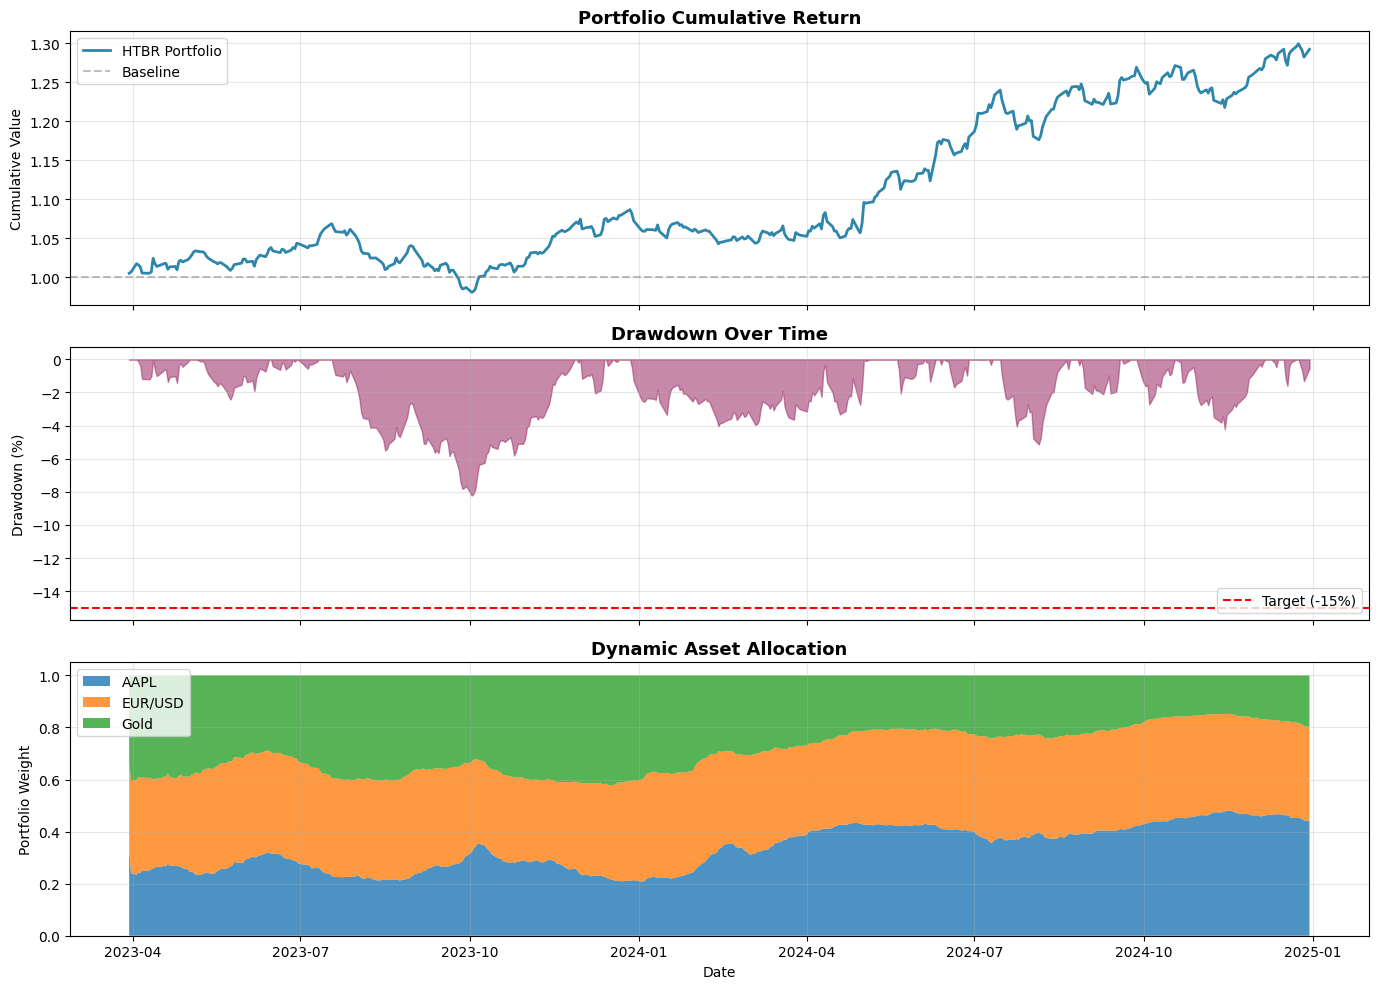

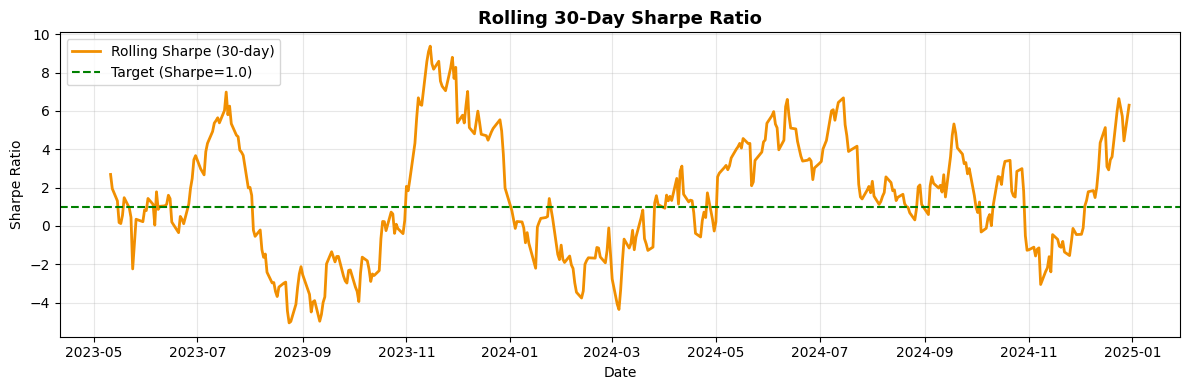


📊 Generating prediction comparison plots...


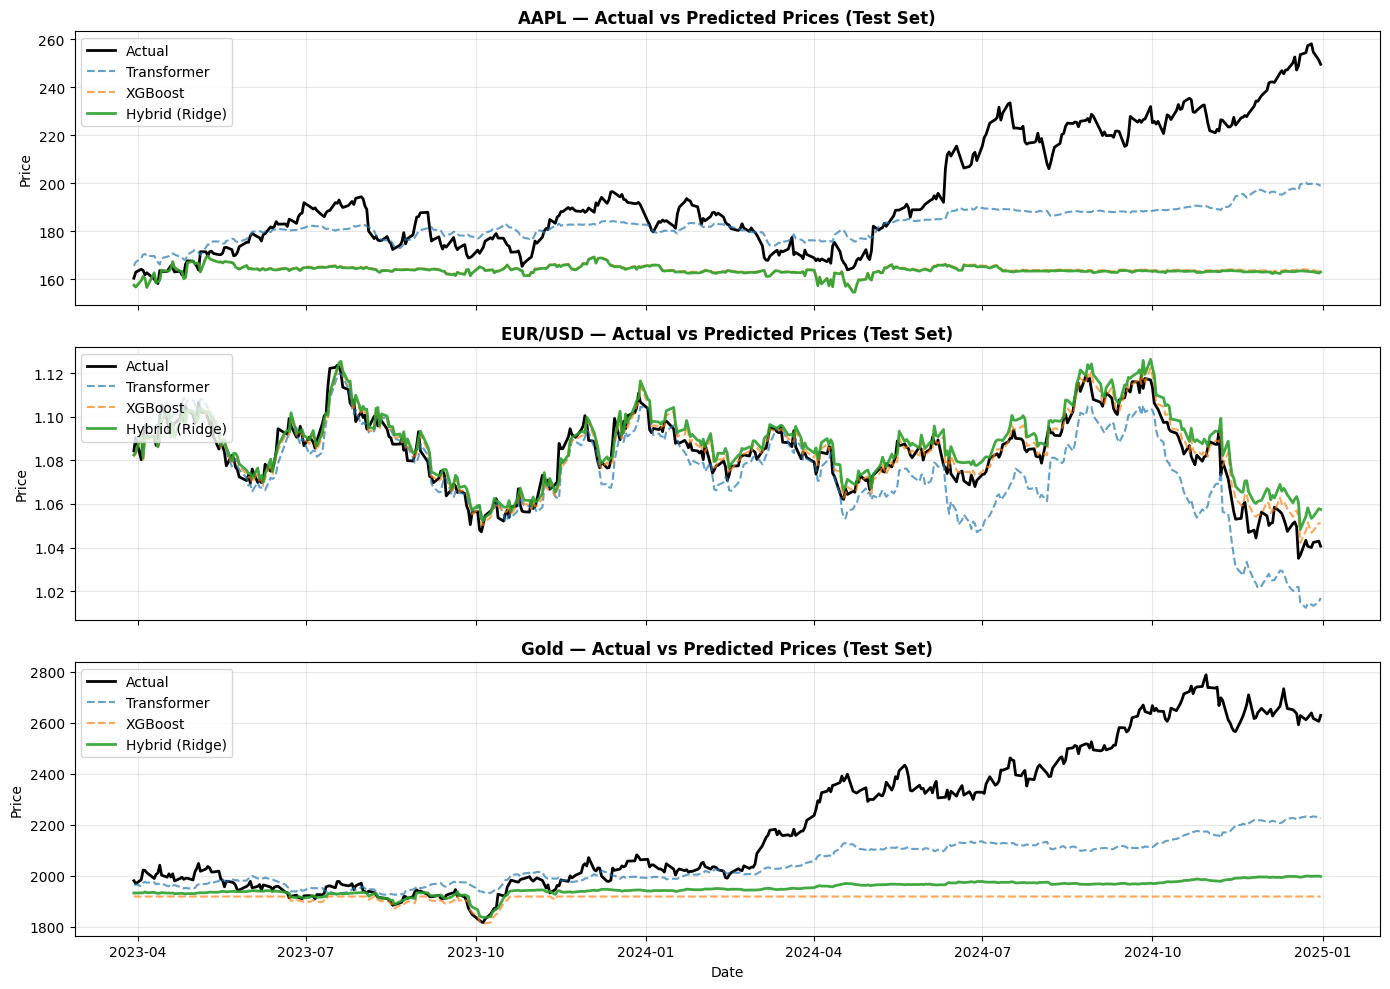

✅ Prediction plots saved as 'price_predictions.png'

✅ Evaluation complete. All plots saved:
   • portfolio_performance.png
   • rolling_sharpe.png
   • price_predictions.png
   • Diagnostics: eval_diagnostics.pkl


In [ ]:
# =============================================================================
# CELL 11: CORRECTED EVALUATION WITH DIAGNOSTIC PLOTS
# =============================================================================

import matplotlib.pyplot as plt
import pandas as pd
import pickle

# Reset eval env and run deterministic policy
obs = env_test.reset()
done = np.array([False])
portfolio_weights = []
daily_returns = []

step_count = 0
base_env = env_test.venv.envs[0]

while not done[0]:
    action, _ = model.predict(obs, deterministic=True)
    current_weights = base_env.prev_w.copy()
    portfolio_weights.append(current_weights)
    obs, reward, done, info = env_test.step(action)

    if step_count < base_env.rets.shape[0]:
        idx = max(0, base_env.t - 1)
        r_assets = base_env.rets[idx] if idx < base_env.rets.shape[0] else np.zeros(base_env.num_assets)
        w = current_weights
        port_return = float(np.dot(w, r_assets))
        prev_w = portfolio_weights[-2] if len(portfolio_weights) > 1 else np.ones(base_env.num_assets) / base_env.num_assets
        turnover = np.sum(np.abs(w - prev_w))
        tc = base_env.tc * turnover
        net_return = port_return - tc
        daily_returns.append(net_return)
    step_count += 1

daily_returns = np.array(daily_returns)
portfolio_weights = np.array(portfolio_weights)

print(f"✅ Collected {len(daily_returns)} daily returns from test period")

# =============================================================================
# METRICS CALCULATION
# =============================================================================
if len(daily_returns) == 0:
    raise RuntimeError("No returns collected. Check env lengths.")

cum_ret = np.exp(np.cumsum(daily_returns))[-1] - 1.0
total_return_pct = cum_ret * 100
daily_mean = np.mean(daily_returns)
daily_std = np.std(daily_returns)
sharpe = (daily_mean / (daily_std + 1e-8)) * np.sqrt(252)
cum_curve = np.exp(np.cumsum(daily_returns))
peak = np.maximum.accumulate(cum_curve)
drawdown_series = (cum_curve - peak) / (peak + 1e-8)
max_dd = np.min(drawdown_series)
ann_vol = daily_std * np.sqrt(252) * 100
turnovers = [np.sum(np.abs(portfolio_weights[i] - portfolio_weights[i-1]))
             for i in range(1, len(portfolio_weights))]
avg_turnover = np.mean(turnovers) if turnovers else 0.0
win_rate = np.sum(daily_returns > 0) / len(daily_returns) * 100

print("\n" + "="*60)
print("EVALUATION METRICS")
print("="*60)
print(f"Cumulative Return: {cum_ret:.4f} ({total_return_pct:.2f}%)")
print(f"Sharpe Ratio: {sharpe:.3f}")
print(f"Max Drawdown: {max_dd:.3f} ({max_dd*100:.2f}%)")
print(f"Annualized Volatility: {ann_vol:.2f}%")
print(f"Average Turnover: {avg_turnover:.5f}")
print(f"Win Rate: {win_rate:.2f}%")
print("="*60)

# =============================================================================
# FIX: Align dates with actual returns length
# =============================================================================
# Test dates should match the length of daily_returns exactly
dates_test = test_df.index[lookback:lookback+len(daily_returns)]

# =============================================================================
# PLOT 1: Portfolio Performance (3 subplots)
# =============================================================================
fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Cumulative returns
axs[0].plot(dates_test, cum_curve, linewidth=2, color='#2E86AB', label='HTBR Portfolio')
axs[0].axhline(y=1, color='gray', linestyle='--', alpha=0.5, label='Baseline')
axs[0].set_title('Portfolio Cumulative Return', fontsize=13, fontweight='bold')
axs[0].set_ylabel('Cumulative Value')
axs[0].legend(loc='upper left')
axs[0].grid(alpha=0.3)

# Drawdown
axs[1].fill_between(dates_test, drawdown_series * 100, 0, color='#A23B72', alpha=0.6)
axs[1].axhline(-15, color='red', linestyle='--', linewidth=1.5, label='Target (-15%)')
axs[1].set_title('Drawdown Over Time', fontsize=13, fontweight='bold')
axs[1].set_ylabel('Drawdown (%)')
axs[1].legend(loc='lower right')
axs[1].grid(alpha=0.3)

# Portfolio weights (stacked area)
asset_names = ['AAPL', 'EUR/USD', 'Gold']
# Trim portfolio_weights to match dates_test length if needed
weights_to_plot = portfolio_weights[:len(dates_test)]
axs[2].stackplot(dates_test, weights_to_plot.T, labels=asset_names, alpha=0.8)
axs[2].set_title('Dynamic Asset Allocation', fontsize=13, fontweight='bold')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Portfolio Weight')
axs[2].legend(loc='upper left')
axs[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('portfolio_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# PLOT 2: Rolling Sharpe Ratio (30-day)
# =============================================================================
window = 30
rolling_sharpes = []
for i in range(window, len(daily_returns)+1):
    slice_ = daily_returns[i-window:i]
    rs = (slice_.mean() / (slice_.std()+1e-8)) * np.sqrt(252)
    rolling_sharpes.append(rs)

plt.figure(figsize=(12, 4))
plt.plot(dates_test[window-1:], rolling_sharpes, linewidth=2, color='#F18F01', label='Rolling Sharpe (30-day)')
plt.axhline(1.0, color='green', linestyle='--', linewidth=1.5, label='Target (Sharpe=1.0)')
plt.title('Rolling 30-Day Sharpe Ratio', fontsize=13, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('rolling_sharpe.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# PLOT 3: Actual vs Predicted Prices (Fixed Dimension Mismatch)
# =============================================================================
print("\n📊 Generating prediction comparison plots...")
try:
    # FIX: Ensure all arrays match in length
    min_len = min(len(y_test), len(trans_test_pred_scaled), len(xgb_test_pred_scaled), len(hybrid_test_pred_scaled))

    # Trim all to same length
    y_test_trimmed = y_test[:min_len]
    trans_pred_trimmed = trans_test_pred_scaled[:min_len]
    xgb_pred_trimmed = xgb_test_pred_scaled[:min_len]
    hybrid_pred_trimmed = hybrid_test_pred_scaled[:min_len]
    dates_pred = test_df.index[lookback:lookback+min_len]

    # Inverse transform
    actual_price_seq = scaler.inverse_transform(y_test_trimmed)
    preds_trans_price = scaler.inverse_transform(trans_pred_trimmed)
    preds_xgb_price = scaler.inverse_transform(xgb_pred_trimmed)
    preds_hybrid_price = scaler.inverse_transform(hybrid_pred_trimmed)

    # Plot for each asset
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

    for i, name in enumerate(asset_names):
        axes[i].plot(dates_pred, actual_price_seq[:, i], label='Actual', linewidth=2, color='black')
        axes[i].plot(dates_pred, preds_trans_price[:, i], label='Transformer', alpha=0.7, linestyle='--')
        axes[i].plot(dates_pred, preds_xgb_price[:, i], label='XGBoost', alpha=0.7, linestyle='--')
        axes[i].plot(dates_pred, preds_hybrid_price[:, i], label='Hybrid (Ridge)', alpha=0.9, linewidth=2)
        axes[i].set_title(f"{name} — Actual vs Predicted Prices (Test Set)", fontsize=12, fontweight='bold')
        axes[i].set_ylabel('Price')
        axes[i].legend(loc='upper left')
        axes[i].grid(alpha=0.3)

    axes[-1].set_xlabel('Date')
    plt.tight_layout()
    plt.savefig('price_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Prediction plots saved as 'price_predictions.png'")

except Exception as e:
    print(f"⚠️  Prediction plots skipped. Error: {e}")

# =============================================================================
# SAVE DIAGNOSTICS
# =============================================================================
diag = {
    "daily_returns": daily_returns,
    "portfolio_weights": portfolio_weights,
    "dates_test": dates_test,
    "cum_curve": cum_curve,
    "drawdown_series": drawdown_series,
    "rolling_sharpes": rolling_sharpes,
    "metrics": {
        "sharpe": sharpe,
        "max_dd": max_dd,
        "cum_ret": cum_ret,
        "ann_vol": ann_vol,
        "avg_turnover": avg_turnover,
        "win_rate": win_rate
    }
}

with open("eval_diagnostics.pkl", "wb") as f:
    pickle.dump(diag, f)

print("\n✅ Evaluation complete. All plots saved:")
print("   • portfolio_performance.png")
print("   • rolling_sharpe.png")
print("   • price_predictions.png")
print("   • Diagnostics: eval_diagnostics.pkl")
